# Personal Finance Insights Dashboard
---

## Objetivo general del EDA

El objetivo principal es comprender los patrones financieros personales, observando cómo influyen factores como la edad, la educación o el empleo en indicadores clave como la deuda, el ahorro y la puntuación crediticia. No hay una única target.


1.	Analizar la relación entre variables financieras clave, como:

	* debt_to_income_ratio: proporción entre deuda e ingresos.
	* credit_score: puntuación crediticia (300–850).
	* savings_to_income_ratio: proporción entre ahorro e ingresos.
	* savings_usd: total ahorros acumulado por individuo.
	
2.	Comparar los indicadores financieros según variables demográficas y laborales:
	* Edad (age).
	* Género (gender).
	* region: zona geográfica de residencia.
	* Nivel educativo (education_level).
	* Situación laboral (employment_status).
	* Puesto de trabajo (job_title).

3.	Identificar posibles patrones o desigualdades financieras entre grupos de población, regiones o tipos de empleo.

4.	Detectar relaciones de interés entre el perfil personal y la estabilidad económica (por ejemplo, cómo varía el credit_score según la educación o la relación entre ingresos y ahorro por tipo de empleo).

---

## Visualizaciones Incluidas

* Distribuciones y boxplots de ratios financieros (DTI, Savings/Income, Credit Score).
* Comparativas por categoría (género, educación, empleo, región).
* Relaciones entre variables numéricas mediante scatter plots y correlaciones.
* Tablas y resúmenes estadísticos para observar diferencias entre grupos.
* Gráficos de barras para analizar medias y medianas de indicadores financieros por categoría.

---

## Valor del Análisis

* Permite entender el comportamiento financiero medio de diferentes perfiles de personas.
* Facilita detectar grupos con mayor riesgo o menor estabilidad económica (por ejemplo, alto DTI o bajo ahorro).
* Proporciona una base sólida para futuras fases de modelado o segmentación, en caso de ampliarse el proyecto.
* Ayuda a visualizar desigualdades financieras entre regiones, niveles educativos o tipos de empleo.

# 1.- Librerías

In [4]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd #manejo de estructura de datos tabulares
import numpy as np # manejo de arrays y operaciones matemáticas

# libreria para crear mapas interactivos
# -----------------------------------------------------------------------
import folium
from folium.plugins import HeatMap, MarkerCluster


# librerias para visualizar datos
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


# Libreria para acceder a funciones del sistema 
# -----------------------------------------------------------------------
import sys 
sys.path.append("../")

# Warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Configuracion de pandas
# -----------------------------------------------------------------------
pd.options.display.max_columns = None

# 2.-Cargar datos

In [6]:
# cargamos los datos limpios
df = pd.read_pickle("../data/processed/Personal_Finance_ML_Dataset_limpio.pkl")
df.reset_index(inplace=True)
df.head()

,index,user_id,age,gender,education_level,employment_status,job_title,monthly_income_usd,monthly_expenses_usd,savings_usd,has_loan,loan_type,loan_amount_usd,loan_term_months,monthly_emi_usd,loan_interest_rate_pct,debt_to_income_ratio,credit_score,savings_to_income_ratio,region,record_date
0,0,U00001,56,Female,High School,Self-employed,Salesperson,3531.69,1182.59,367655.03,False,No_loan,0.00,0,0.00,0.00,0.00,430,8.68,Other,2024-01-09
1,1,U00002,19,Female,PhD,Employed,Salesperson,3531.73,2367.99,260869.10,True,Education,146323.34,36,4953.50,13.33,1.40,543,6.16,North America,2022-02-13
2,2,U00003,20,Female,Master,Employed,Teacher,2799.49,1003.91,230921.21,False,No_loan,0.00,0,0.00,0.00,0.00,754,6.87,Africa,2022-05-12
3,3,U00004,25,Male,PhD,Employed,Manager,5894.88,4440.12,304815.51,True,Business,93242.37,24,4926.57,23.93,0.84,461,4.31,Europe,2023-10-02
4,4,U00005,53,Female,PhD,Employed,Student,5128.93,4137.61,461509.48,False,No_loan,0.00,0,0.00,0.00,0.00,516,7.50,Africa,2021-08-07


# 3.- Análisis General

## 3.1.- Tablas de resumen (visión rápida)

#### 1.- Enmarcar el dataset

In [11]:
kpis = {
    "n_personas": len(df),
    "n_columnas": df.shape[1],
    "min_fecha": df.record_date.min(),
    "max_fecha": df.record_date.max()
}
pd.Series(kpis)

n_personas                  32424
n_columnas                     21
min_fecha     2021-07-23 00:00:00
max_fecha     2025-07-22 00:00:00
dtype: object

#### 	2.	Tabla de descriptivos clave (media y mediana) de:
debt_to_income_ratio, credit_score, savings_to_income_ratio, savings_usd.Esto establece rangos y posibles outliers.

In [12]:
num_cols = ["debt_to_income_ratio","credit_score","savings_to_income_ratio","savings_usd"]
resumen = df[num_cols].describe(percentiles=[.25,.5,.75]).T
resumen[["mean","50%","min","25%","75%","max"]].round(2)

,mean,50%,min,25%,75%,max
debt_to_income_ratio,1.19,0.00,0.00,0.00,0.92,90.67
credit_score,575.26,575.00,300.00,437.00,714.00,850.00
savings_to_income_ratio,5.05,5.04,0.10,2.58,7.51,10.00
savings_usd,243752.04,201700.33,635.96,86291.55,358966.22,1237774.39


In [ ]:
# Esto muestra una línea con el % de ceros (estructural, sin préstamo).
(df["debt_to_income_ratio"].eq(0).mean()*100).round(2)

np.float64(59.95)

## 3.2 Distribuciones univariantes (forma y outliers)

#### 1.- Histogramas + KDE de debt_to_income_ratio, savings_to_income_ratio, savings_usd, credit_score.
Se pretende ver sesgo y colas largas.

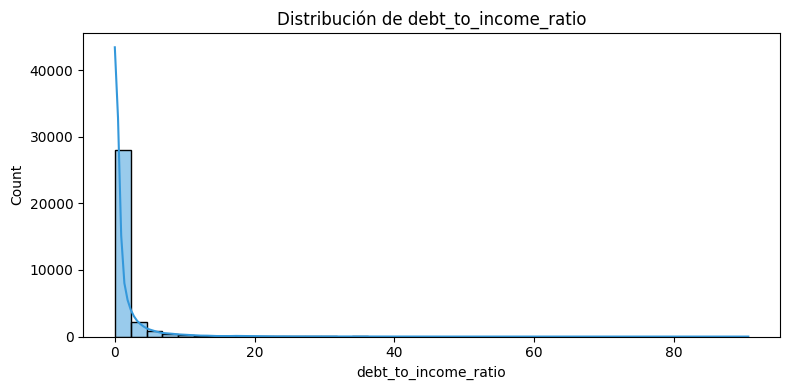

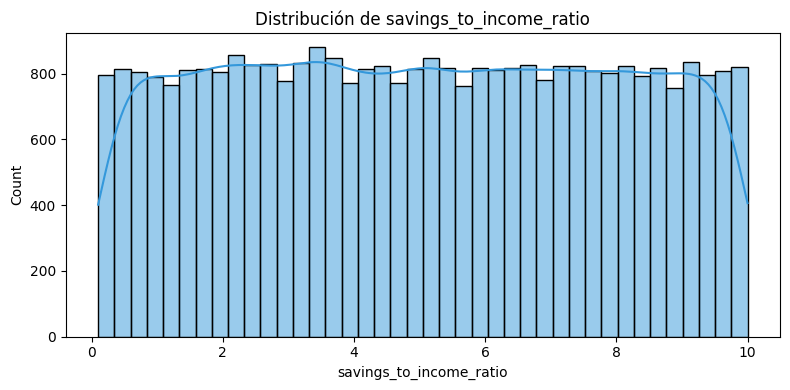

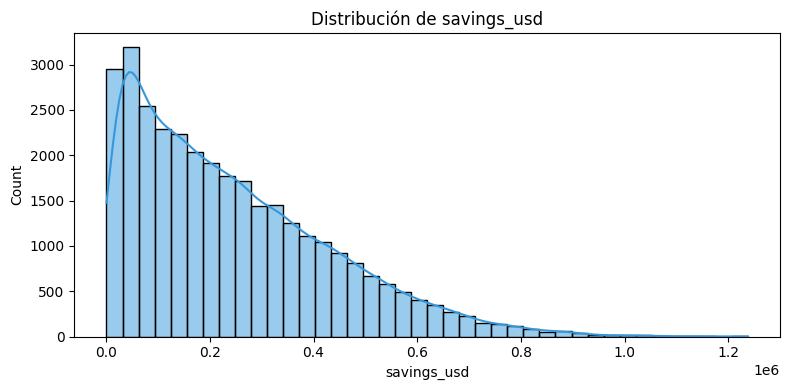

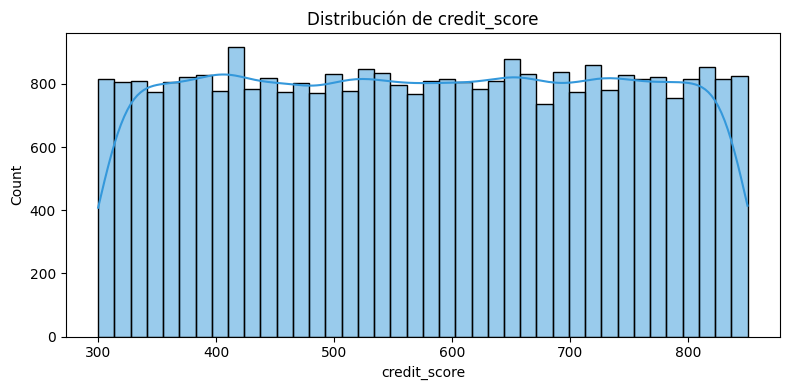

In [14]:
color_total = '#3498db'
for c in ["debt_to_income_ratio","savings_to_income_ratio","savings_usd","credit_score"]:
    plt.figure(figsize=(8,4))
    sns.histplot(df[c], bins=40, kde=True, color=color_total)
    plt.title(f"Distribución de {c}")
    plt.tight_layout(); plt.show()

#### 2.-	Boxplots de las mismas variables.
Con esto se pretende hacerlo mismo que antes pero para detectar outliers de un vistazo.

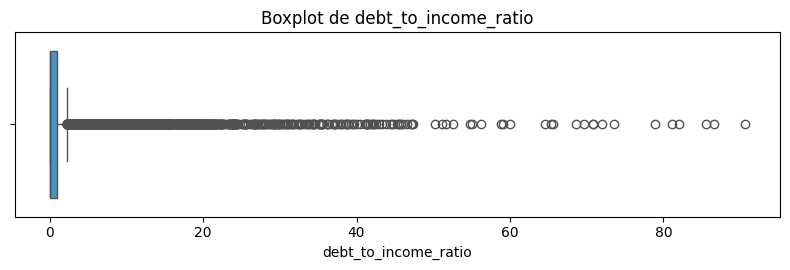

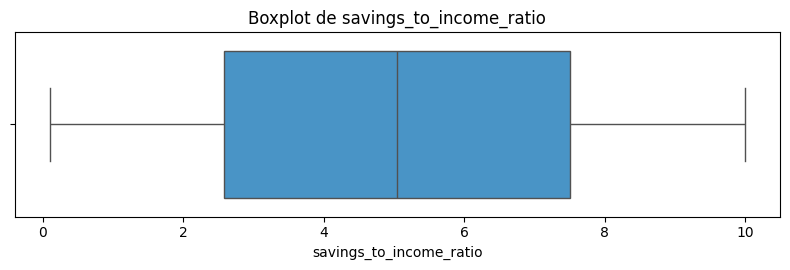

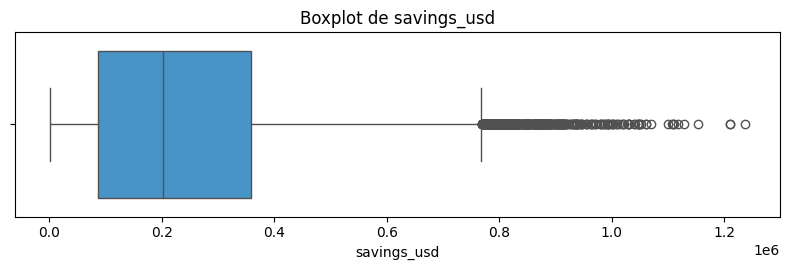

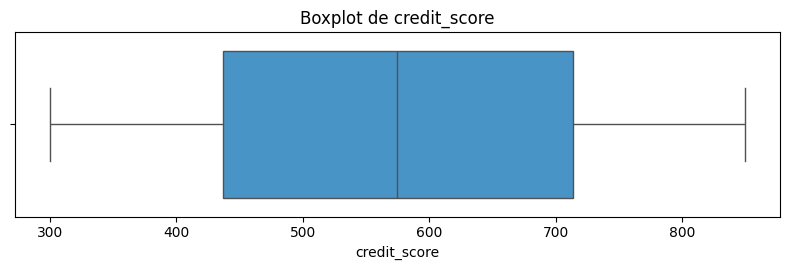

In [15]:
for c in ["debt_to_income_ratio","savings_to_income_ratio","savings_usd","credit_score"]:
    plt.figure(figsize=(8,2.8))
    sns.boxplot(x=df[c], color=color_total)
    plt.title(f"Boxplot de {c}")
    plt.tight_layout(); plt.show()

#### 3.-	Crédit Score por bandas (Poor/Fair/Good/Very Good/Excellent).
Esto clasifica la población por calidad crediticia.

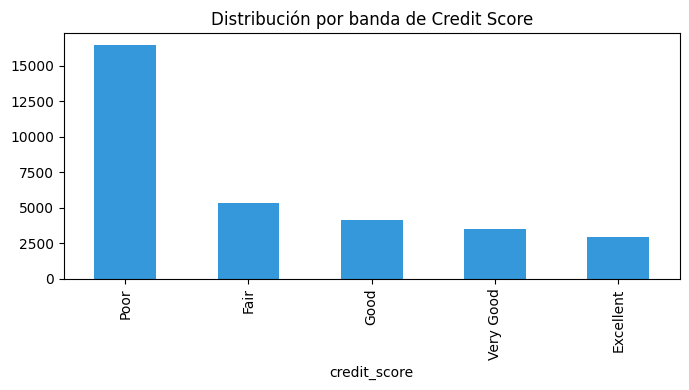

In [16]:
bins  = [300,580,670,740,800,850]
labels= ["Poor","Fair","Good","Very Good","Excellent"]
score_band = pd.cut(df["credit_score"], bins=bins, labels=labels, include_lowest=True)
score_band.value_counts().reindex(labels).plot(kind="bar", color=color_total, figsize=(7,4))
plt.title("Distribución por banda de Credit Score"); plt.tight_layout(); plt.show()

## 3.3 Relaciones bivariantes numéricas (panorama)

#### 1.- **Ingreso vs Gastos** (contexto financiero).
Sirve para ver la población “ahorradora” (por debajo de la línea 45°) vs “deficitaria” (los que gastan).

NameError: name 'color_churned' is not defined

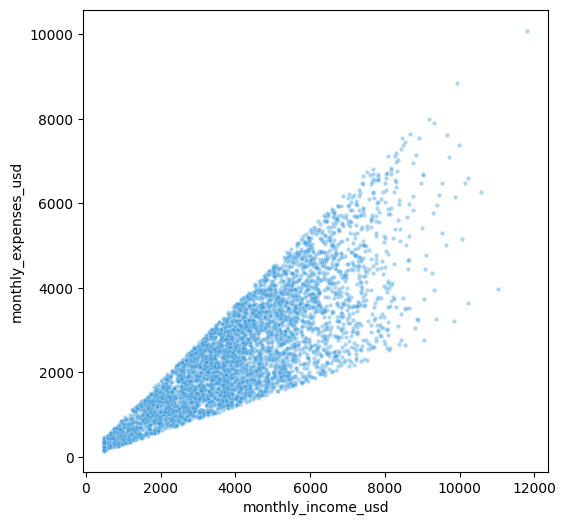

In [17]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df.sample(min(len(df), 5000), random_state=42),
                x="monthly_income_usd", y="monthly_expenses_usd", s=10, alpha=.4, color=color_total)
lim = max(df["monthly_income_usd"].quantile(.99), df["monthly_expenses_usd"].quantile(.99))
plt.plot([0,lim],[0,lim], color=color_churned, lw=1.5)  # línea y=x
plt.title("Income vs Expenses (muestra)"); plt.tight_layout(); plt.show()

#### 2.- **Scatter DTI vs Credit Score** con línea de tendencia.

In [18]:
plt.figure(figsize=(7,5))
sns.regplot(data=df.sample(min(len(df), 8000), random_state=42),
            x="debt_to_income_ratio", y="credit_score",
            scatter_kws=dict(s=10, alpha=.3, color=color_total),
            line_kws=dict(color=color_activos))
plt.title("Relación DTI vs Credit Score"); plt.tight_layout(); plt.show()

NameError: name 'color_activos' is not defined

<Figure size 700x500 with 0 Axes>

#### 3.- **Scatter Savings/Income vs Credit Score.**

In [19]:
plt.figure(figsize=(7,5))
sns.regplot(data=df.sample(min(len(df), 8000), random_state=42),
            x="savings_to_income_ratio", y="credit_score",
            scatter_kws=dict(s=10, alpha=.3, color=color_total),
            line_kws=dict(color=color_activos))
plt.title("Savings/Income vs Credit Score"); plt.tight_layout(); plt.show()

NameError: name 'color_activos' is not defined

<Figure size 700x500 with 0 Axes>

## 3.4.- Correlaciones rápidas)

#### 1.- Matriz de correlación de variables numéricas clave.
El objetivo es saber qué pares explorar después en el apartado 4 del EDA

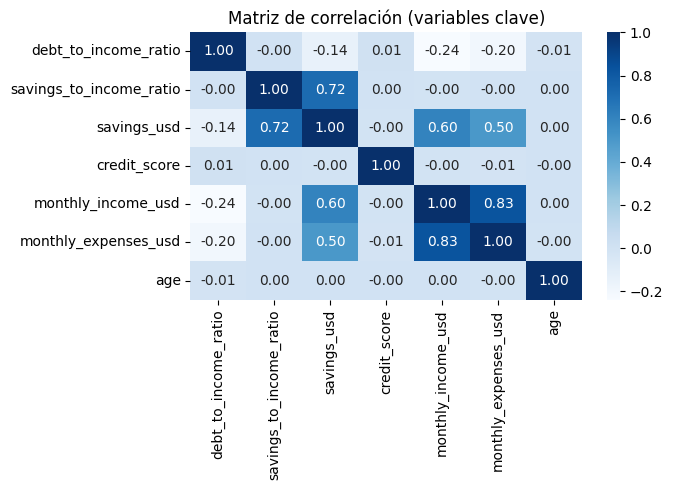

In [20]:
num_cols = ["debt_to_income_ratio","savings_to_income_ratio","savings_usd","credit_score",
            "monthly_income_usd","monthly_expenses_usd","age"]
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matriz de correlación (variables clave)"); plt.tight_layout(); plt.show()

## 3.5.- Panorama categórico (frecuencias principales)

#### 1.- Top categorías: region, education_level, employment_status, job_title (Top-10).
El objetivo es entender el “peso” de cada grupo antes de pasar al apartado 4 del EDA.

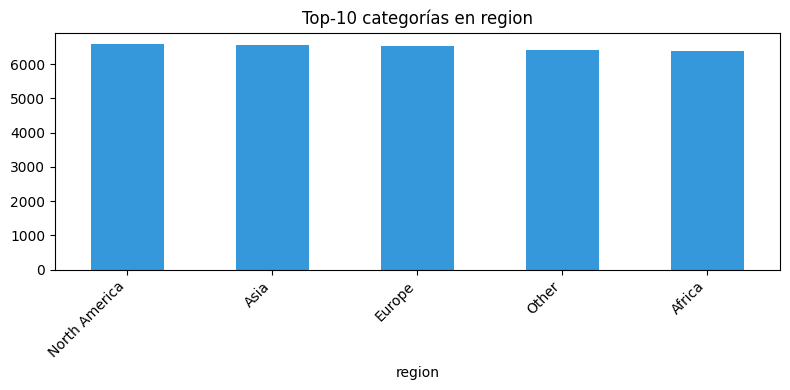

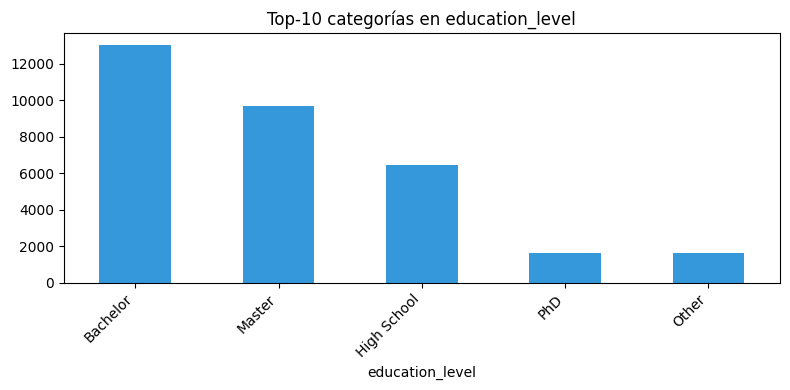

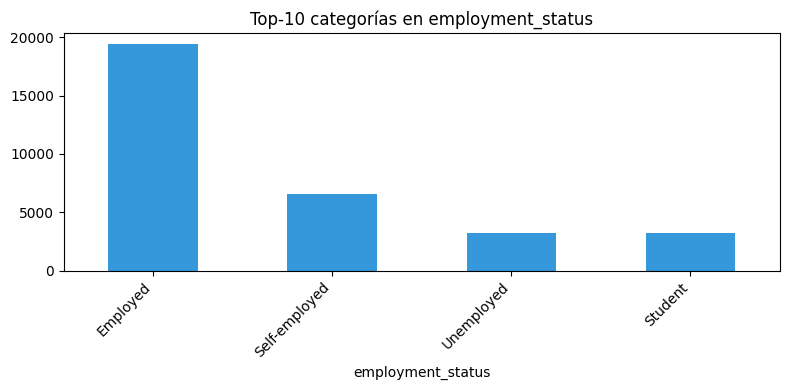

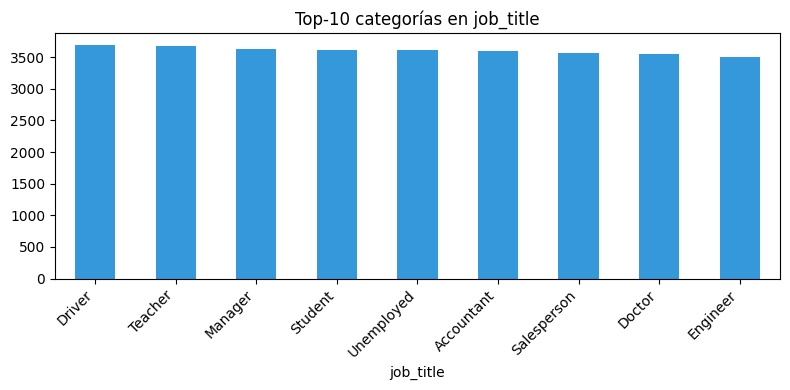

In [21]:
cats = ["region","education_level","employment_status","job_title"]
for c in cats:
    plt.figure(figsize=(8,4))
    df[c].value_counts().head(10).plot(kind="bar", color=color_total)
    plt.title(f"Top-10 categorías en {c}"); plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()

#### 2.- Tarta de region (usa tu paleta donas).

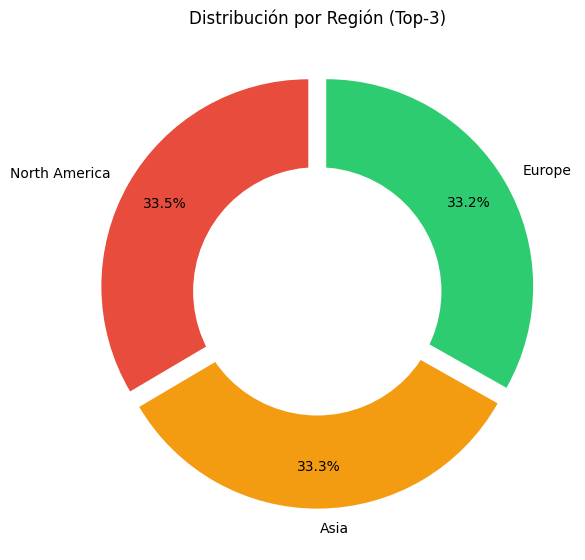

In [22]:
values = df["region"].value_counts().head(3)
colors_donut = ['#e74c3c', '#f39c12', '#2ecc71']; explode = (0.05,0.05,0.05)
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(values, labels=values.index, colors=colors_donut, explode=explode,
       autopct='%1.1f%%', startangle=90, pctdistance=.8)
centre = plt.Circle((0,0),0.60,fc='white'); fig.gca().add_artist(centre)
ax.set_title("Distribución por Región (Top-3)"); plt.tight_layout(); plt.show()

# 4.- Análisis estructurado 

## 4.1.- Análisis Demográfico y Geográfico

#### 1.- age

- age vs debt_to_income_ratio

In [ ]:
# Tabla

In [7]:
# gráfico

- age vs credit_score

In [8]:
# tabla

In [ ]:
# gráfico

- age vs savings_to_income_ratio

In [ ]:
# tabla

In [ ]:
# gráfico

- age vs savings_usd

In [ ]:
# tabla

In [9]:
# gráfico

#### 2.- gender

- gender vs debt_to_income_ratio

In [ ]:
# tabla

In [10]:
# gráfico

- gender vs savings_to_income_ratio

In [ ]:
# tabla

In [ ]:
# gráfico

- gender vs credit_score

In [ ]:
# tabla

In [ ]:
# gráfico

- gender vs savings_usd

In [ ]:
# tabla

In [ ]:
# gráfico

#### 3.- education_level

- education_level vs debt_to_income_ratio

In [ ]:
# tabla

In [ ]:
# gráfico

- education_level vs savings_to_income_ratio

In [ ]:
# tabla

In [ ]:
# gráfico

- education_level vs credit_score

In [ ]:
# tabla

In [ ]:
# gráfico

- education_level vs savings_usd

In [ ]:
# tabla

In [ ]:
# gráfico

#### 4.- region

- regio vs debt_to_income_ratio

In [ ]:
# tabla

In [ ]:
# gráfico

- region vs savings_to_income_ratio

In [ ]:
# tabla

In [ ]:
# gráfico

- region vs credit_score

In [ ]:
# tabla

In [ ]:
# gráfico

- region vs savings_usd

In [ ]:
# tabla

In [ ]:
# gráfico

# Next Steps

- Profundizar en el análisis correlacional entre ratios financieros.
- Explorar la distribución del score crediticio por región y situación laboral.
- Analizar los niveles de ahorro en relación con los ingresos y la edad.
- Documentar los hallazgos visuales y las conclusiones generales del EDA.